In [1]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11,6)
import pandas as pd
pd.set_option('display.max_columns', 50)

import category_encoders as ce
from datetime import datetime, timedelta

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
df = pd.read_csv('data.csv')
# display(df.describe())
# display(df.head())

### Class Proportions (Response = 'ordersuccess')

In [3]:
success = df[df['ordersuccess']==1]
fail = df[df['ordersuccess']==0]

success_num = len(success)
fail_num = len(fail)
total = len(df)

print('Number of order successes: ', success_num)
print('Proportion of order successes: ', success_num / (success_num + fail_num))
print('Number of order failures: ', fail_num)
print('Proportion of order failures: ', fail_num / (success_num + fail_num))

Number of order successes:  28190
Proportion of order successes:  0.05021044213331149
Number of order failures:  533247
Proportion of order failures:  0.9497895578666885


### Null Values

In [4]:
# countNaN = len(df) - df.count() #count of NaN values = count of all values (len(df)) - count of non-NaN values (df.count)
# display(countNaN)

## Preprocessing

In [5]:
def getTimeMS(t):
    if '.' in t:
        timestamp, ms = t.split('.')
    else:
        timestamp = t
        ms = 0
    time_obj = datetime.strptime(timestamp, '%H:%M:%S')
    epoch = datetime(1900, 1, 1, 0, 0, 0, 0)
    milliseconds = (time_obj - epoch) // timedelta(milliseconds=1)
    return milliseconds + float(ms)*1000

df['time_ms'] = df['starttime'].apply(lambda x: getTimeMS(x))


#continuous features
cont_features = df.loc[:,['time_ms','size','minexecqty','limitprice','prevailbid','prevailask','prevailbidsize','prevailasksize',
                          'dispatcherrebalance','lotsize','averagespread','misavgbidsize1min','misavgasksize1min', 
                          'misavgspread1min', 'misoddlotvolume1min', 'misadfvolume1min','misvolume1min']]

#one-hot encoded features
dummies = pd.get_dummies(df.loc[:,['side','venuetype','securitycategory', 'peginstruction',
                                   'sector','mktcap']].astype('category'),drop_first=True)

#binary encoded features
enc = ce.BinaryEncoder()
binary_sym = enc.fit_transform(df.loc[:,'symbol'].as_matrix())
names = {'0_0':'symbol_0', '0_1':'symbol_1','0_2':'symbol_2','0_3':'symbol_3','0_4':'symbol_4',
         '0_5':'symbol_5','0_6':'symbol_6','0_7':'symbol_7','0_8':'symbol_8','0_9':'symbol_9',
         '0_10':'symbol_10','0_11':'symbol_11','0_12':'symbol_12'}
binary_sym = binary_sym.rename(columns=names)

binary_venue = enc.fit_transform(df.loc[:,'venue'].as_matrix())
names = {'0_0':'venue_0', '0_1':'venue_1','0_2':'venue_2',
         '0_3':'venue_3','0_4':'venue_4','0_5':'venue_5','0_6':'venue_6'}
binary_venue = binary_venue.rename(columns=names)

adv20d = df.loc[:,'adv20d'].fillna(0)

features = pd.concat([adv20d, cont_features, dummies, binary_sym, binary_venue], axis=1)

response = df.loc[:,'ordersuccess']

df = pd.concat([features,response],axis=1)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


## Train / Test Split

In [6]:
train = df.head(round(total*.70))
test = df.tail(round(total*.30))

train_success = train[train['ordersuccess']==1]
train_fail = train[train['ordersuccess']==0]

test_success = test[test['ordersuccess']==1]
test_fail = test[test['ordersuccess']==0]

## Downsampling

In [7]:
downsampled_fails = train_fail.sample(n=len(train_success))

#recombine and shuffle data
train_downsampled = pd.concat([downsampled_fails, train_success],axis=0)
train_downsampled = train_downsampled.sample(frac=1).reset_index(drop=True)

train_downsampled.head()

,adv20d,time_ms,size,minexecqty,limitprice,prevailbid,prevailask,prevailbidsize,prevailasksize,dispatcherrebalance,lotsize,averagespread,misavgbidsize1min,misavgasksize1min,misavgspread1min,misoddlotvolume1min,misadfvolume1min,misvolume1min,side_Sell,venuetype_Dark,venuetype_Gray,venuetype_Single-Dealer,securitycategory_COMMON,securitycategory_ETF,securitycategory_FUND,...,sector_Test,sector_Utilities,mktcap_MID,mktcap_SMALL,symbol_0,symbol_1,symbol_2,symbol_3,symbol_4,symbol_5,symbol_6,symbol_7,symbol_8,symbol_9,symbol_10,symbol_11,symbol_12,venue_0,venue_1,venue_2,venue_3,venue_4,venue_5,venue_6,ordersuccess
0,200000.0,38305000.0,500,0,20.00,20.00,20.04,600,200,0,100,0.052353,342,507,0.045076,0,3900,4500,1,1,0,0,1,0,0,...,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1
1,8000000.0,37362000.0,100,0,296.18,296.06,296.18,100,200,0,100,0.182941,179,451,0.209079,5450,18757,33499,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0
2,200000.0,37691000.0,95,0,2.55,2.55,2.60,278300,58700,0,100,0.050000,278300,58700,0.050000,11,11,11,1,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,1,1,1,1,0,0,1,1,0,0,1,0,0,0,1,0
3,2500000.0,37938000.0,200,100,38.74,38.72,38.74,1200,100,0,100,0.014737,1934,301,0.022192,158,404,3227,0,0,1,0,1,0,0,...,0,0,1,0,0,0,1,0,1,1,1,1,1,0,1,1,0,0,0,0,1,0,0,0,1
4,400000.0,39621000.0,3,0,309.65,309.50,309.65,100,100,0,100,0.213529,100,143,0.224857,118,16,118,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,1,1,1,0,0,1,1,0,0,0,0,0,1,0,1,1


## More Data Preparation

In [8]:
train_features = train_downsampled.loc[:,train_downsampled.columns != 'ordersuccess']
train_response = train_downsampled.loc[:,'ordersuccess']

test_features = test.loc[:,test.columns != 'ordersuccess']
test_response = test.loc[:,'ordersuccess']

## Model Evaluation Functions

In [9]:
def cm2df(cm, labels): 
    """converts a numpy array confusion matrix to a pandas dataframe, with class labels"""
    df = pd.DataFrame()
    # rows
    for i, row_label in enumerate(labels):
        rowdata={}
        # columns
        for j, col_label in enumerate(labels): 
            rowdata[col_label]=cm[i,j]
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    return df[labels]

def model_eval(y_test, y_pred): 
    """prints out a confusion matrix (pandas dataframe) and classification report"""
    conf_mat = confusion_matrix(y_test, y_pred)
    cm_as_df=cm2df(conf_mat,[0,1])
    new_names = {0:'Order Fail',1:'Order Success'}
    cm_as_df = cm_as_df.rename(index=new_names, 
                                 columns=new_names)
    print('\n')
    print('CONFUSION MATRIX (predicted along top, actual along side): ')
    display(cm_as_df)

    print('\n')
    print(classification_report(y_test,y_pred,target_names=['Order Fail','Order Success']))
    
def cross_validation(model, features, response, num_folds):
    metrics = ['precision_macro', 'recall_macro', "f1_macro"]
    cv = cross_validate(model, features, response, scoring=metrics, cv=num_folds)
    print("Test data set average precision across 5 folds:")
    print(cv['test_precision_macro'])
    print("\nTest data set average recall across 5 folds:")
    print(cv['test_recall_macro'])
    print("\nTest data set average fscore across 5 folds:")
    print(cv['test_f1_macro'])
    
def plot_roc_curve(model, X_test, y_test):
    probabilities = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, probabilities)
    print('AUC: %.3f' % auc)

    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    # plot no skill curve
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

## Logistic Regression



CONFUSION MATRIX (predicted along top, actual along side): 


,Order Fail,Order Success
Order Fail,83714,75793
Order Success,1961,6963




               precision    recall  f1-score   support

   Order Fail       0.98      0.52      0.68    159507
Order Success       0.08      0.78      0.15      8924

  avg / total       0.93      0.54      0.65    168431

AUC: 0.694


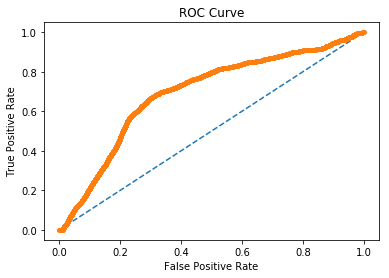

In [10]:
logreg = LogisticRegression()

logreg.fit(train_features, train_response)

y_pred = logreg.predict(test_features)
model_eval(test_response, y_pred)

plot_roc_curve(logreg, test_features, test_response)

# cross_validation(logreg, features, response, 5)

## Decision Tree



CONFUSION MATRIX (predicted along top, actual along side): 


,Order Fail,Order Success
Order Fail,115909,43598
Order Success,2766,6158




               precision    recall  f1-score   support

   Order Fail       0.98      0.73      0.83    159507
Order Success       0.12      0.69      0.21      8924

  avg / total       0.93      0.72      0.80    168431

AUC: 0.708


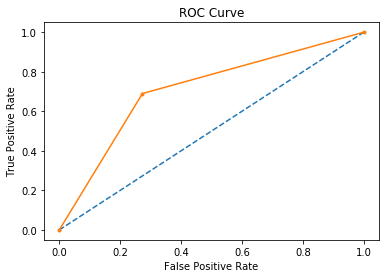

KeyboardInterrupt: 

In [11]:
CART = DecisionTreeClassifier()

CART.fit(train_features, train_response)

y_pred = CART.predict(test_features)
model_eval(test_response, y_pred)

plot_roc_curve(CART, test_features, test_response)

# cross_validation(CART, features, response, 5)

## Random Forest



CONFUSION MATRIX (predicted along top, actual along side): 


,Order Fail,Order Success
Order Fail,128304,31203
Order Success,2741,6183




               precision    recall  f1-score   support

   Order Fail       0.98      0.80      0.88    159507
Order Success       0.17      0.69      0.27      8924

  avg / total       0.94      0.80      0.85    168431

AUC: 0.839


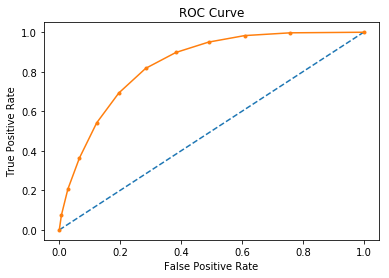

In [12]:
RF = RandomForestClassifier()

RF.fit(train_features, train_response)

y_pred = RF.predict(test_features)
model_eval(test_response, y_pred)

plot_roc_curve(RF, test_features, test_response)

# cross_validation(RF, features, response, 5)